In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('credit_card_data.csv')

In [5]:
df.card = (df.card == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [8]:
categorical = ['owner', 'selfmp']

numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [10]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %3f' % (c, auc))

  reports, 0.716663
      age, 0.524002
   income, 0.590805
    share, 0.989184
expenditure, 0.991042
dependents, 0.532776
   months, 0.529422
majorcards, 0.534386
   active, 0.604317


In [11]:
columns = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active', 'owner', 'selfemp']

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
x_val = dv.transform(val_dicts)

y_pred = model.predict_proba(x_val)[:, 1]

In [12]:
roc_auc_score(y_val, y_pred)

0.995171242063847

In [13]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.fn)
    
    return df_scores

In [14]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [15]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,1,36,0.925110,0.944444
20,0.2,207,5,4,48,0.976415,0.555556
30,0.3,205,5,6,48,0.976190,0.454545
40,0.4,205,1,6,52,0.995146,0.142857
50,0.5,204,1,7,52,0.995122,0.125000
60,0.6,204,1,7,52,0.995122,0.125000
70,0.7,204,1,7,52,0.995122,0.125000
80,0.8,204,1,7,52,0.995122,0.125000
90,0.9,204,0,7,53,1.000000,0.000000


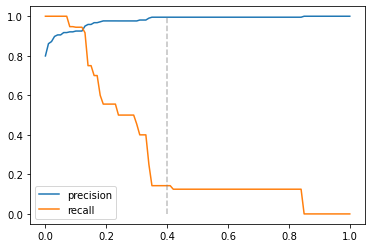

In [16]:
plt.plot(df_scores.threshold, df_scores.tpr, label='precision')
plt.plot(df_scores.threshold, df_scores.fpr, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

In [17]:
df_scores['f1'] = 2 * df_scores.tpr * df_scores.fpr / (df_scores.tpr + df_scores.fpr)

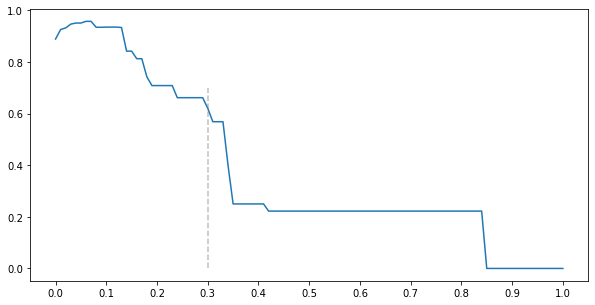

In [18]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [19]:
from sklearn.model_selection import KFold

In [24]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(x_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')
    
    x = dv.transform(dicts)
    y_pred = model.predict_proba(x)[:, 1]
    
    return y_pred

In [28]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003
